In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.float = float
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import time
from IPython.display import display, clear_output
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import utils

In [2]:
df_meta = pd.read_csv("/Users/labadmin/Projects/immusign/data/lymphoma-reps-file-infos.csv")
lymphoma_types = df_meta["lymphoma_specification"].unique()

In [3]:
df_meta.columns

Index(['pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'clones.txt.name', 'subject_id', 'sex',
       'dosc', 'age', 'dob'],
      dtype='object')

In [4]:
lymphoma_types

array(['cll', 'hd', 'unspecified', 'abc_dlbcl', 'nlphl', 'thrlbcl',
       'dlbcl', 'lymphadenitis', 'gcb_dlbcl'], dtype=object)

In [46]:
df_raw = []
for file in tqdm(df_meta["clones.txt.name"].values):
    df_file = pd.read_csv("/Users/labadmin/Projects/immusign/data/clones_mit_kidera/%s" % file, sep="\t")
    df_file["clones.txt.name"] = file
    df_raw.append(df_file)
df_raw = pd.concat(df_raw)
df_raw["cloneFraction"] = df_raw["cloneFraction"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

  0%|          | 0/1394 [00:00<?, ?it/s]

In [51]:
df_raw.columns

Index(['cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3', 'aaSeqCDR3',
       'bestVGene', 'bestDGene', 'bestJGene', 'vBestIdentityPercent',
       'lengthOfCDR3', 'targetSequences', 'allVGenes', 'allDGenes',
       'allJGenes', 'allVHits', 'allDHits', 'allJHits', 'allVAlignments',
       'allDAlignments', 'allJAlignments', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5',
       'KF6', 'KF7', 'KF8', 'KF9', 'KF10', 'clones.txt.name',
       'dBestIdentityPercent', 'jBestIdentityPercent', 'aaSeqCDR2',
       'aaSeqCDR1', 'aaSeqFR2', 'aaSeqFR3', 'aaSeqFR4',
       'aaSeqImputedVDJRegion'],
      dtype='object')

# Load Data read from R-Script

In [7]:
import rpy2.robjects as robjects
robjects.r['load']("/Users/labadmin/Projects/immusign/immusign_40000_reads_with_mutations.RData")
twb = robjects.r['twb']

In [18]:
df = utils.convert_rtwb_to_pdtwb(twb)

In [19]:
df["clones.txt.name"] = df["sample"].apply(lambda x: x + ".clones.txt")

In [20]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name'],
      dtype='object')

# Add metric info

In [21]:
stats = pd.read_csv("/Users/labadmin/Projects/immusign/output/stats.csv", sep=";")
stats.rename(columns={stats.columns[0]:"sample"}, inplace=True)

In [22]:
df = df.merge(stats.iloc[:-2], on = "sample")

In [23]:
df = df.merge(df_meta, on = "clones.txt.name")

In [24]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob'],
      dtype='object')

# Add correct clone Id before adding info from raw files

In [108]:
df["cloneId"] = None

for file in tqdm(df["clones.txt.name"].unique()):
    df_sub_file = df[df["clones.txt.name"] == file]
    df_raw_sub_file = df_raw[df_raw["clones.txt.name"] == file]
    for i, index_row in enumerate(df_sub_file.iterrows()):
        index, row = index_row[0], index_row[1]  
        if row["CDR3.nucleotide.sequence"] == df_raw_sub_file.iloc[i]["nSeqCDR3"]:
            df.loc[index,"cloneId"] = df_raw_sub_file.iloc[i]["cloneId"]

  0%|          | 0/679 [00:00<?, ?it/s]

In [116]:
df2 = df.merge(df_raw, left_on=["clones.txt.name", "cloneId", "CDR3.nucleotide.sequence"], right_on =["clones.txt.name", "cloneId", "nSeqCDR3"], how = "left")

In [55]:
df2.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [122]:
#df2.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data.pkl")

# Small Analysis

In [52]:
df = pd.read_pickle("immusign_40000_reads_with_out_of_frame_merged_raw_data.pkl")

In [5]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

## Columns
cloneId --> Identified clones per sample <br>
cloneCount --> Absolute number found in sample <br>
cloneFraction --> Relative number found in sample (Attention: smaller than cloneCount/sum(cloneCount) because cut off < 2<br>
nSeqCDR3 --> Nucleotid sequence <br>
aaSeqCDR3 --> Amino Acid Sequence <br>
bestVGene --> best matching VGene <br>
bestDGene --> best matching DGene <br>
bestJGene --> best matching JGene <br>
vBestIdentityPercent --> Certainty of best matching VGene <br>
lengthOfCDR3 --> length of nucleotid sequence <br>
targetSequences --> Full sequence of nSeqCDR3 <br>
allVGenes --> All possible matches of V genes<br>
allDGenes --> All possible matches of D genes <br>
allJGenes --> All possible matches of J genes <br>
allVHits --> All V hits <br>
allDHits --> All D hits <br>
allJHits --> All J hits <br>
allVAlignments --> Alignments for each V hit <br>
allDAlignments --> Alignments for each D hit <br>
allJAlignments --> Alignments for each J hit <br>
KF1 - KF10 --> Kidera Factors <br>
clones.txt.name --> Sample file <br>
dBestIdentityPercent  --> Certainty of best matching DGene  <br>
jBestIdentityPercent  --> Certainty of best matching JGene  <br>
aaSeqCDR2 --> Amino Acid Sequence <br>
aaSeqCDR1 --> Amino Acid Sequence <br>
aaSeqFR2 --> Amino Acid Sequence  <br>
aaSeqFR3 --> Amino Acid Sequence  <br>
aaSeqFR4 --> Amino Acid Sequence <br>
aaSeqImputedVDJRegion --> Amino Acid Sequence <br>
<br>
--- META DATA ---<br>
pcr_target_locus --> Target Region of PCR ('IGH', 'TRB', 'IGHFR3', 'IGHFR2', 'TRBFR3') <br>
organism --> Organism of sample (hs) <br>
template --> DNA <br>
tissue --> Blood or Tissue['pb', 'tm'] <br>
lymphoma_type --> Identified lymphoma type <br>
lymphoma_specification --> dentified lymphoma type <br>
subject_id <br>
sex <br>
dosc --> date of sample collection <br>
age <br>
dob -->  date of birth<br>


In [4]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
Umi.count,1546613.0,17.418807,397.543918,2.000000e+00,4.000000,6.000000,11.000000,40000.000000
Umi.proportion,1546613.0,0.000439,0.009979,5.004504e-05,0.000093,0.000148,0.000278,1.000000
Read.count,1546613.0,17.418807,397.543918,2.000000e+00,4.000000,6.000000,11.000000,40000.000000
Read.proportion,1546613.0,0.000439,0.009979,5.004504e-05,0.000093,0.000148,0.000278,1.000000
VD.insertions,1546613.0,5.062404,19.777911,-2.360000e+02,-1.000000,2.000000,5.000000,229.000000
DJ.insertions,1546613.0,2.773265,4.625236,-2.200000e+01,-1.000000,1.000000,5.000000,190.000000
Total.insertions,1546613.0,8.295069,19.792461,-1.000000e+00,0.000000,4.000000,10.000000,242.000000
cloneCount,1546613.0,32.809663,1036.315576,3.000000e+00,6.000000,10.000000,20.000000,552029.000000
cloneFraction,1546613.0,0.000412,0.009906,1.070000e-12,0.000074,0.000126,0.000252,0.999821
vBestIdentityPercent,1535920.0,0.988703,0.027926,6.666667e-01,0.994624,1.000000,1.000000,1.000000


<Axes: xlabel='lymphoma_specification', ylabel='Count'>

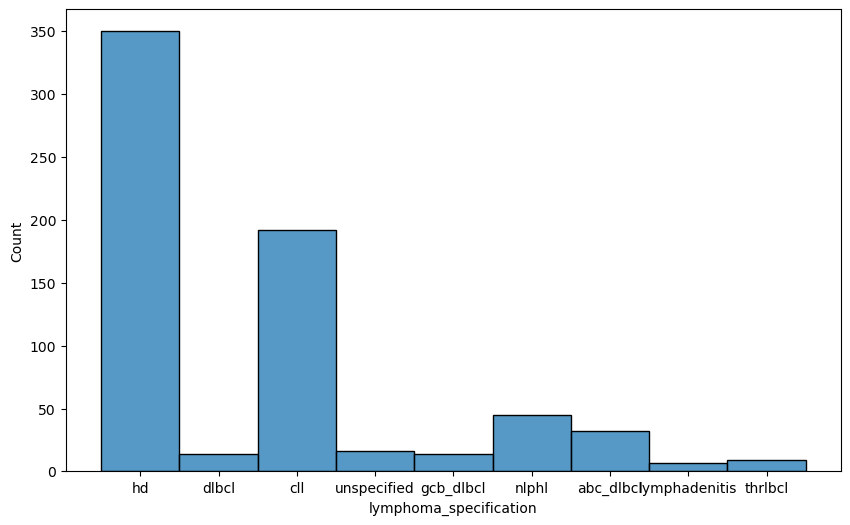

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["lymphoma_specification"],ax = ax)

In [10]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [11]:
df_mutations = df[df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)]
mutations_per_group = df_mutations.groupby("lymphoma_specification").apply(len).reset_index()
total_per_group = df.groupby("lymphoma_specification").apply(len).reset_index()

In [12]:
total_per_group

,lymphoma_specification,0
0,abc_dlbcl,8846
1,cll,101752
2,dlbcl,8955
3,gcb_dlbcl,2498
4,hd,1162418
5,lymphadenitis,46484
6,nlphl,181327
7,thrlbcl,14480
8,unspecified,19853


In [13]:
mutations_per_group

,lymphoma_specification,0
0,abc_dlbcl,859
1,cll,15315
2,dlbcl,1204
3,gcb_dlbcl,314
4,hd,170284
5,lymphadenitis,4951
6,nlphl,20802
7,thrlbcl,1557
8,unspecified,2494


In [14]:
mutations_per_group[0]/total_per_group[0]

0    0.097106
1    0.150513
2    0.134450
3    0.125701
4    0.146491
5    0.106510
6    0.114721
7    0.107528
8    0.125623
Name: 0, dtype: float64

Text(0, 0.5, 'non-productive AA (%)')

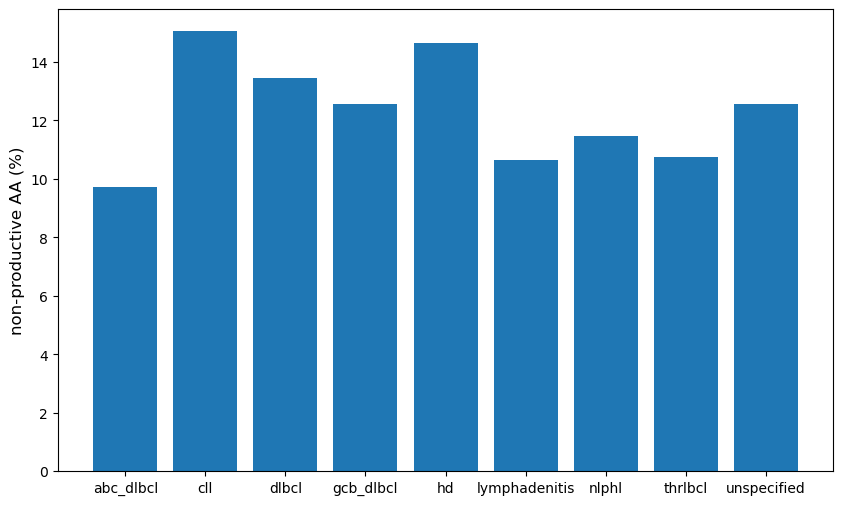

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mutations_per_group["lymphoma_specification"],mutations_per_group[0]/total_per_group[0] * 100)
ax.set_ylabel("non-productive AA (%)", size=12)

In [16]:
mutations_per_patient = df_mutations.groupby("clones.txt.name").apply(len).reset_index()
total_per_patient = df.groupby("clones.txt.name").apply(len).reset_index()

In [17]:
mutations_per_patient = mutations_per_patient.merge(total_per_patient, on="clones.txt.name",how="left")

In [18]:
mutations_per_patient = mutations_per_patient.merge(df_mutations[["clones.txt.name","lymphoma_specification"]], on="clones.txt.name", how="left")

In [29]:
mutations_per_patient["non-productive AA (%)"] = mutations_per_patient["0_x"]/mutations_per_patient["0_y"] * 100

In [20]:
mutations_per_patient.sort_values(by="lymphoma_specification", inplace = True)

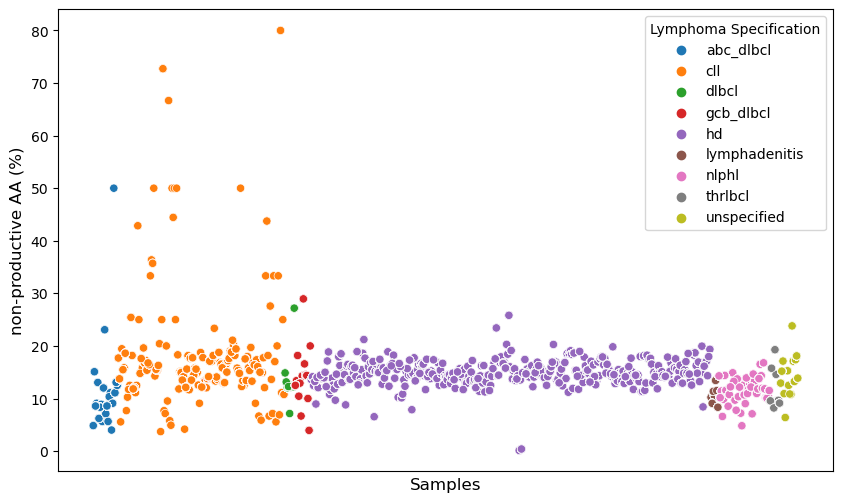

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='clones.txt.name', y='non-productive AA (%)', hue='lymphoma_specification', data=mutations_per_patient) 
ax.set_xticks([])
ax.set_ylabel("non-productive AA (%)", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

# Simple Logistic Regression

In [53]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [55]:
df["Clonality"] = df["Clonality"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.shannon"] = df["twb.shannon"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.simp"] = df["twb.simp"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

In [97]:
def tryconvert(value, default, *types):
    for t in types:
        try:
            return t(value)
        except (ValueError, TypeError):
            continue
    return default

In [99]:
df["age"] = df["age"].apply(lambda x: tryconvert(x, np.nan, float))

In [164]:
np.sum(df["age"].isnull())

213328

In [131]:
np.sum(df["sex"].isnull())

209223

In [191]:
X = df[["lymphoma_specification", 'bestVGene','Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10']].copy()

## Get info about nan values

In [192]:
print("bestVGene: ", X.bestVGene.isnull().sum(), X.bestVGene.dtype)
print("Read.proportion: ", X["Read.proportion"].isnull().sum(), X["Read.proportion"].dtype)
print("Clonality: ", X["Clonality"].isnull().sum(), X["Clonality"].dtype)
print("twb.shannon: ", X["twb.shannon"].isnull().sum(), X["twb.shannon"].dtype)
print("twb.shannon: ", X["twb.simp"].isnull().sum(), X["twb.simp"].dtype)
print("lengthOfCDR3: ", X.lengthOfCDR3.isnull().sum(), X.lengthOfCDR3.dtype)
print("KF1: ", X.KF1.isnull().sum(), X.KF1.dtype)
print("KF2: ", X.KF2.isnull().sum(), X.KF2.dtype)
print("KF3: ", X.KF3.isnull().sum(), X.KF3.dtype)
print("KF4: ", X.KF4.isnull().sum(), X.KF4.dtype)
print("KF5: ", X.KF5.isnull().sum(), X.KF5.dtype)
print("KF6: ", X.KF6.isnull().sum(), X.KF6.dtype)
print("KF7: ", X.KF7.isnull().sum(), X.KF7.dtype)
print("KF8: ", X.KF8.isnull().sum(), X.KF8.dtype)
print("KF9: ", X.KF9.isnull().sum(), X.KF9.dtype)
print("KF10: ", X.KF10.isnull().sum(), X.KF10.dtype)

bestVGene:  0 object
Read.proportion:  0 float64
Clonality:  8 float64
twb.shannon:  0 float64
twb.shannon:  0 float64
lengthOfCDR3:  0 int64
KF1:  0 float64
KF2:  0 float64
KF3:  0 float64
KF4:  0 float64
KF5:  0 float64
KF6:  0 float64
KF7:  0 float64
KF8:  0 float64
KF9:  0 float64
KF10:  0 float64


In [193]:
X.dropna(inplace = True)

In [194]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

categorical_preprocessor = OneHotEncoder(handle_unknown = 'ignore')
numerical_preprocessor = StandardScaler()
target_preprocessor = LabelEncoder()

In [195]:
Y_target = target_preprocessor.fit_transform(X["lymphoma_specification"])

In [196]:
Y_target

array([4, 4, 4, ..., 1, 1, 1])

In [198]:
labels = []
for i in range(len(X["lymphoma_specification"].unique())):
    labels.append(np.asarray(X["lymphoma_specification"])[Y_target==i][0])

In [199]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_target, random_state=42
)

In [200]:
X_train.columns

Index(['lymphoma_specification', 'bestVGene', 'Read.proportion', 'Clonality',
       'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4',
       'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
      dtype='object')

In [201]:
X_train.iloc[:, 2:] = numerical_preprocessor.fit_transform(X_train.iloc[:, 2:])
X_test.iloc[:, 2:] = numerical_preprocessor.transform(X_test.iloc[:, 2:])

In [202]:
transformed_categoris_train = categorical_preprocessor.fit_transform(X_train.iloc[:,1:2])
transformed_categoris_test = categorical_preprocessor.transform(X_test.iloc[:,1:2])

In [203]:
transformed_categoris_train = pd.DataFrame(data = transformed_categoris_train.todense(), columns=categorical_preprocessor.categories_[0])
transformed_categoris_test = pd.DataFrame(data = transformed_categoris_test.todense(), columns=categorical_preprocessor.categories_[0])

In [204]:
X_train = pd.concat([X_train.reset_index(drop=True), transformed_categoris_train], axis=1) 
X_test = pd.concat([X_test.reset_index(drop=True), transformed_categoris_test], axis=1) 

In [178]:
from sklearn.linear_model import LogisticRegression

In [205]:
model = LogisticRegression(max_iter=500)
model.fit(X_train.iloc[:,2:], y_train)

/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [206]:
coefficients = model.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)

<Axes: ylabel='Feature'>

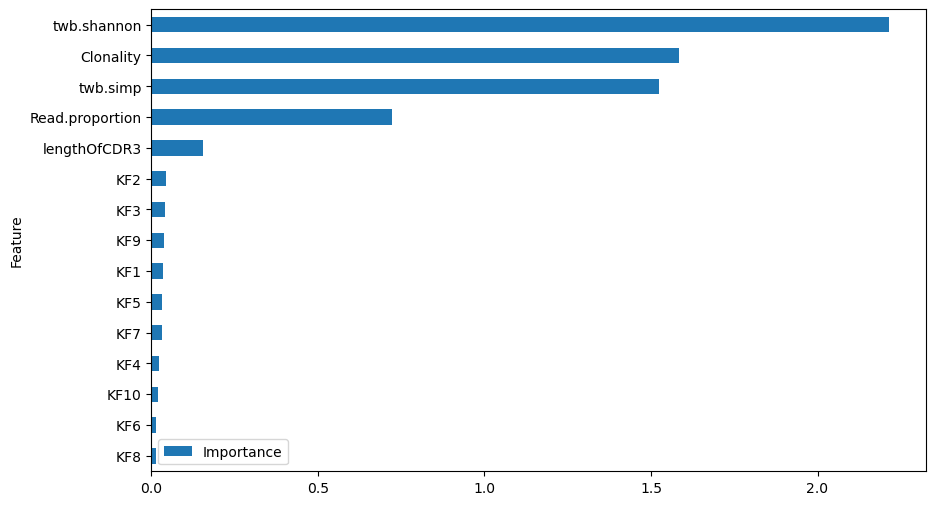

In [207]:
feature_importance = pd.DataFrame({'Feature': X_train.columns[2:17], 'Importance': avg_importance[0:15]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [208]:
y_pred = model.predict(X_test.iloc[:,2:])

In [209]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=np.asarray(labels)))

/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

    abc_dlbcl       0.48      0.50      0.49      2157
          cll       0.65      0.35      0.46     25453
        dlbcl       0.27      0.08      0.13      2249
    gcb_dlbcl       0.41      0.18      0.25       609
           hd       0.87      0.96      0.91    290563
lymphadenitis       0.05      0.01      0.02     11683
        nlphl       0.63      0.63      0.63     45378
      thrlbcl       0.00      0.00      0.00      3690
  unspecified       0.46      0.15      0.22      4870

     accuracy                           0.83    386652
    macro avg       0.42      0.32      0.35    386652
 weighted avg       0.78      0.83      0.80    386652



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [210]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

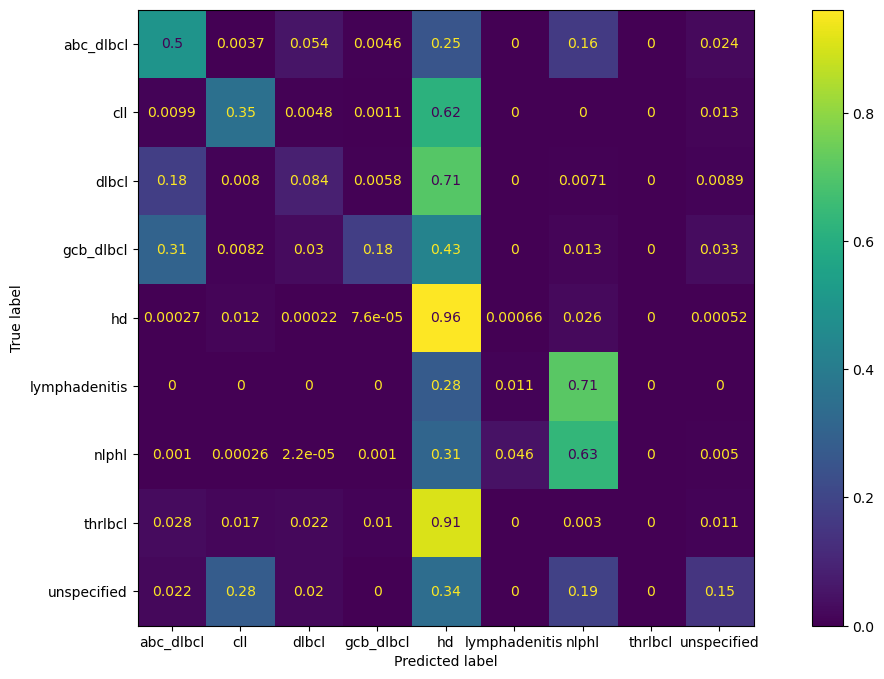

In [211]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(ax=ax)

# SVM with RBF Kernel

In [3]:
from sklearn.svm import SVC

In [150]:
model = SVC(kernel='rbf')
model.fit(X_train.iloc[:,3:], y_train)

SVC()

In [152]:
y_pred = model.predict(X_test.iloc[:,3:])

In [153]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=np.asarray(labels)))

               precision    recall  f1-score   support

    abc_dlbcl       0.42      0.24      0.31       429
          cll       0.56      0.43      0.49      1685
        dlbcl       1.00      0.05      0.10       118
    gcb_dlbcl       0.63      0.07      0.13       166
           hd       0.64      0.93      0.76      2872
lymphadenitis       0.00      0.00      0.00        39
        nlphl       0.39      0.26      0.31       422
      thrlbcl       0.00      0.00      0.00        98
  unspecified       1.00      0.01      0.02       233

     accuracy                           0.60      6062
    macro avg       0.52      0.22      0.23      6062
 weighted avg       0.59      0.60      0.54      6062



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

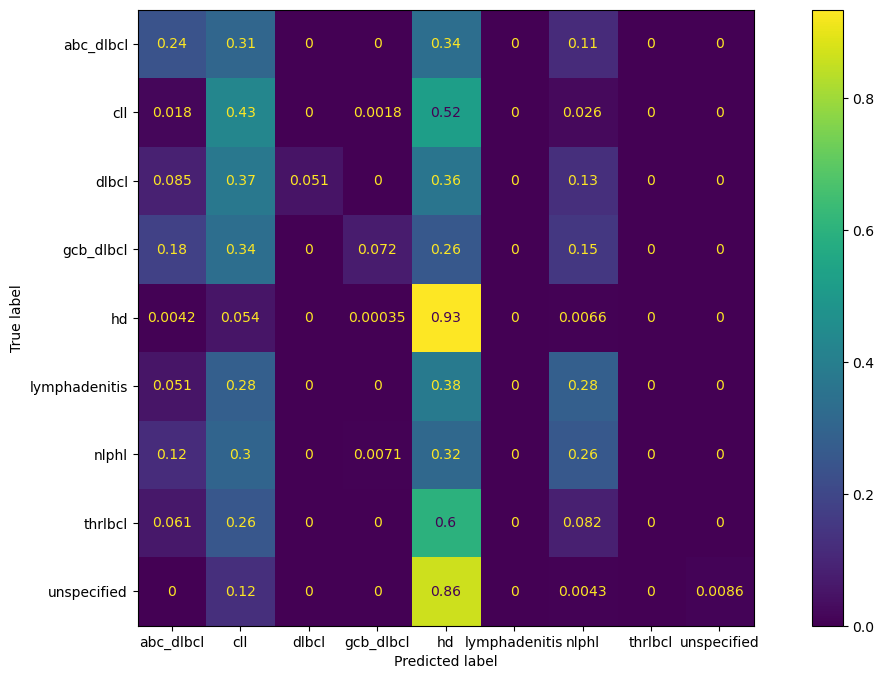

In [171]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(ax=ax)

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='pred')
fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(ax=ax)

# ANN

In [13]:
np.unique(np.concatenate(df["aaSeqCDR3"].apply(lambda x: np.unique(list(x)))))

array(['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '_'], dtype='<U1')

In [25]:
a = np.zeros((10,5))
b = np.asarray([0,1,4,2,3,3,1,2,0,0])
a[np.arange(len(a)),b] = 1

In [26]:
a

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
lymphoma_specification_dict = {"cll":[0,0,1,0,0,0], 
                               "hd":[1,0,0,0,0,0],  
                               "unspecified":[0,0,0,0,0,1], 
                               "abc_dlbcl":[0,1,0,0,0,0], 
                               "nlphl":[0,0,0,1,0,0] , 
                               "thrlbcl":[0,1,0,0,0,0], 
                               "dlbcl":[0,1,0,0,0,0],
                               "lymphadenitis": [0,0,0,0,1,0], 
                               "gcb_dlbcl": [0,1,0,0,0,0]}
#lymphoma_specification_dict = {"cll":2, "hd":0,  "unspecified":5, "abc_dlbcl":1, "nlphl":3 , "thrlbcl":1, "dlbcl":1,
#                         "lymphadenitis": 4, "gcb_dlbcl": 1}

In [7]:
nSeq_look_up_dict = {"A": [1,0,0,0], "C" : [0,1,0,0], "G" : [0,0,1,0], "T" : [0,0,0,1]}
#nSeq_look_up_dict = {"A": 0, "C" : 1, "G" : 2, "T" : 3}
def encode_nucleotides(nSeq):
    return np.stack(list(map(lambda x: nSeq_look_up_dict[x], nSeq)))

In [144]:
X = df[df["cloneId"] == 0]["nSeqCDR3"].apply(encode_nucleotides)
Y = df[df["cloneId"] == 0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [145]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, random_state=42
)

X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [146]:
length_with_index_dict = {}
lengths = np.asarray(X_train.apply(len))
for i in np.sort(np.unique(lengths)):
    length_with_index_dict[i] = np.where(lengths == i)[0]

In [147]:
SEED = 42
random.seed(SEED)

def apply_padding(xx, max_len, style="zero"):
    if len(xx.shape)>=1:
        seq_length = xx.shape[0]
    else:
        seq_length = 1
    padding_size = max_len - seq_length
    if style == "same":
        padding_size = tuple([padding_size] + [1 for i in range(len(xx.shape) - 1)])
        xx = np.concatenate((xx, np.tile(xx[-1:], padding_size)), axis=0)
    elif style == "zero":
        padding_size = tuple([padding_size] + list(xx.shape[1:]))
        xx = np.concatenate((xx, np.zeros(padding_size)), axis=0)
    else:
        raise ValueError("unkown padding style: %s" % style) 
    return xx


def pad_batch_online(batch_lens, batch_data, style="zero"):
    max_len = int(max(batch_lens))
    padded_data = np.stack(list(batch_data.apply(
        lambda x: apply_padding(x, max_len, style=style))))
    return padded_data

def create_epoch_with_same_size_batching(length_with_index_dict,batch_size, shuffle=True):
    epoch = [] # list of batches
    foundlings = []  # rest samples for each length which do not fit into one batch
    
    for length in np.sort(list(length_with_index_dict.keys())): # iterate over each unique length in training data
        length_idxs = length_with_index_dict[length] # dictionary containing indices of samples with length
        rest = len(length_idxs) % batch_size
        if shuffle:
            random.shuffle(length_idxs) # shuffle indices
        epoch += [length_idxs[i * batch_size:(i * batch_size) + batch_size] for i in
                  range(int(len(length_idxs) / batch_size))] # cut into batches and append to epoch
        if rest > 0:
            foundlings += list(length_idxs[-rest:]) # remaining indices which do not fit into one batch are stored in foundling
    foundlings = np.asarray(foundlings)
    rest = len(foundlings) % batch_size
    epoch += [foundlings[i * batch_size:(i * batch_size) + batch_size] for i in
              range(int(len(foundlings) / batch_size))] # cut foudnlings into batches (because inserted sorted this ensures minimal padding)
    if rest > 0:
        epoch += [foundlings[-rest:]] # put rest into one batch (allow smaller batch)
    if shuffle:
        random.shuffle(epoch)
    return epoch

In [112]:
class LinearModel(torch.nn.Module):
    def __init__(self,
                 input_channel = 4,
                 output_channel = 1):
        super().__init__()
        
        self.linear = torch.nn.Linear(input_channel, output_channel)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x, *args):
        output = self.linear(x)
        output = output.mean([1, 2])
        output = self.sigmoid(output)
        return output


class NonLinearModel(torch.nn.Module):
    def __init__(self,
                 input_channel=4,
                 output_channel=1,
                 hidden_units=256,
                 activation_function=torch.nn.LeakyReLU()):
        
        super().__init__()
        self.activation_function = activation_function
        self.non_linear = torch.nn.Linear(input_channel, hidden_units)
        self.linear = torch.nn.Linear(hidden_units, output_channel)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, *args):
        output = self.non_linear(x)
        output = self.activation_function(output)     
        output = self.linear(output)
        output = output.mean([1, 2])
        output = self.sigmoid(output)
           
        return output


class ResnetModel(torch.nn.Module):
    def __init__(self,
                 input_channel,
                 output_channel,
                 hidden_units,
                 hidden_layers,
                 activation_function=torch.nn.LeakyReLU()):
        super().__init__()
        self.input_channel = input_channel
        self.hidden_units = hidden_units
        self.activation_function = activation_function

        self.resid_layers = torch.nn.ModuleList(
            [torch.nn.Linear(input_channel, hidden_units)])
        self.resid_layers = self.resid_layers.extend(torch.nn.ModuleList(
            [torch.nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers - 1)]))
        self.output_layer = torch.nn.Linear(hidden_units, output_channel)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, *args):
        output = x
        for i, block in enumerate(self.resid_layers):
            resid = output
            output = block(output)
            output = self.activation_function(output)
            if i == 0:
                if self.input_channel == self.hidden_units:
                    output += resid
            else:
                output += resid

        output = self.output_layer(output)
        output = output.mean([1])
        output = self.softmax(output)
        return output

In [156]:
class LSTMNet(torch.nn.Module):
    
    def __init__(self,input_dim, hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super(LSTMNet,self).__init__()
        # LSTM layer process the vector sequences 
        #self.embedding = torch.nn.Embedding(vocab_size,embedding_dim)
        
        self.lstm = torch.nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        
        # Dense layer to predict 
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self,seq,seq_len):
        
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        #packed_input = torch.nn.utils.rnn.pack_padded_sequence(seq, seq_len.cpu(),batch_first=True, enforce_sorted = False).to(torch.float)
        output, (h_n, _) = self.lstm(seq)
        output = torch.stack([output[i, (last - 1).long(), :] for i, last in enumerate(seq_len)])
        output=self.fc(output)    
        output=self.softmax(output)

        return output

In [149]:
torch.manual_seed(SEED)

In [192]:
INPUT_DIM = 4
NUM_HIDDEN_NODES = 256
NUM_OUTPUT_NODES = 6
NUM_LAYERS = 4
BIDIRECTION = False
DROPOUT = 0.5

In [193]:
model = LSTMNet(INPUT_DIM, 
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               )

In [397]:
model = LinearModel(input_channel=1)

In [421]:
model = NonLinearModel(input_channel=1)

In [114]:
model = ResnetModel(input_channel=4,output_channel=6,hidden_layers=5,hidden_units=128)

In [376]:
model = Deep()

In [194]:
#device = torch.device("cpu")
device = torch.device("cpu")
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()

In [195]:
model.train()

LSTMNet(
  (lstm): LSTM(4, 256, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [196]:
BATCH_SIZE =16
N_EPOCHS = 200

In [82]:
batch_input.shape

torch.Size([16, 66, 4])

In [81]:
batch_output_jj.shape

torch.Size([16, 6])

In [197]:
epoch_loss = []
epoch_acc = []
for ii in tqdm(range(N_EPOCHS), desc ='Training...',position=0,leave=True):
    average_epoch_loss = []
    average_epoch_metric = []
    average_epoch_acc = []
    
    running_loss = 0.0
    epoch = create_epoch_with_same_size_batching(length_with_index_dict, BATCH_SIZE , shuffle=True)

    for jj, idxs in enumerate(tqdm(epoch,desc = "Batch...",position=1, leave=False)): #enumerate(epoch):
        model.train()
        # index by indices in batch

        batch_input_jj = X_train.iloc[idxs]
        
        batch_input_jj_lens = torch.from_numpy(X_train_lens.iloc[idxs].values).to(device)
        
        batch_input = pad_batch_online(batch_input_jj_lens, batch_input_jj, style="zero")
        batch_input = torch.from_numpy(batch_input).to(torch.float32).to(device)

        #Y_hat = model(batch_input.squeeze())
        Y_hat = model(batch_input, batch_input_jj_lens)

        #batch_output_jj = torch.from_numpy(Y.iloc[idxs].values).to(device)
        batch_output_jj = torch.from_numpy(np.stack(Y_train.iloc[idxs].values)).to(device)


        optimizer.zero_grad() # set gradients to zero before performing backprop
        loss = criterion(Y_hat.squeeze(), batch_output_jj.to(torch.float32))
        average_epoch_loss += [loss.item()]
        
        #f1score = metric(Y_hat, batch_output_jj)
        #average_epoch_metric += [f1score.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

        model.eval()
        #Y_hat = model(batch_input.squeeze())
        Y_hat = model(batch_input, batch_input_jj_lens)
        acc = (Y_hat.round().squeeze() == batch_output_jj).float().mean()
        acc = float(acc)
        average_epoch_acc += [acc]
    
    epoch_loss += [np.mean(average_epoch_loss)]
    epoch_acc += [np.mean(average_epoch_acc)]
    #print("Avg Training Loss: " + str(np.mean(average_epoch_loss)) + "\n" +
    #      #"Avg Training Score: " + str(np.mean(average_epoch_metric)) + "\n" +
    #      "Running Training Loss: " + str(float(running_loss)))
    #time.sleep(0.1)
    

Training...:   0%|          | 0/200 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

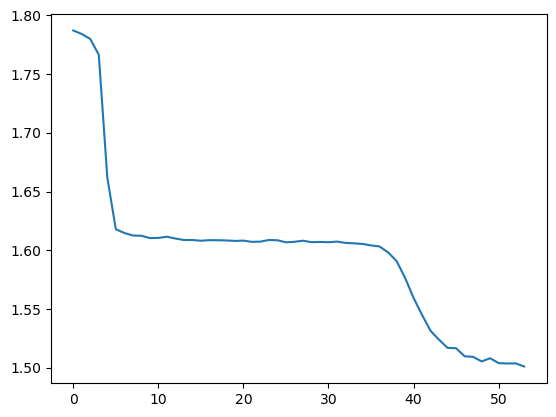

In [198]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss)), epoch_loss)

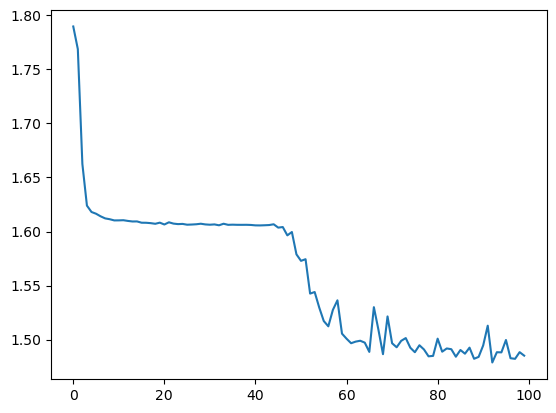

In [39]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss)), epoch_loss)

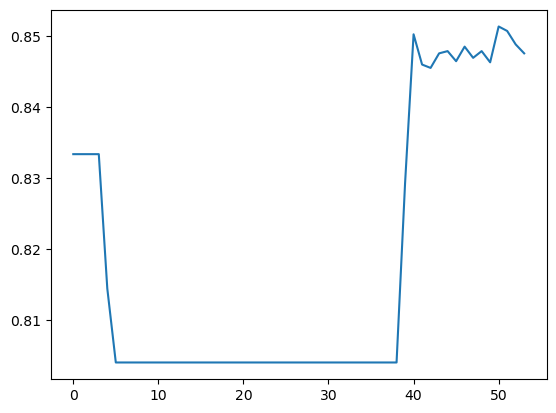

In [199]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

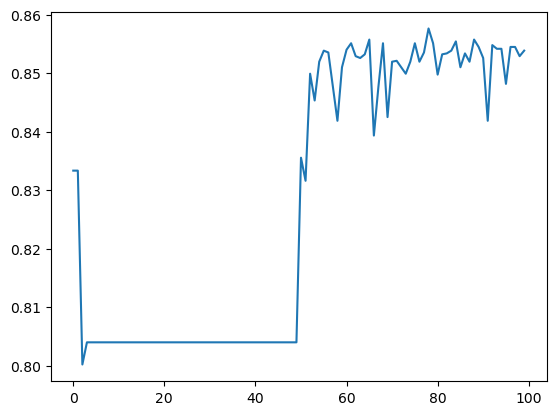

In [40]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

In [200]:
model.eval()
true_labels = []
pred_labels = []
for i,x in tqdm(enumerate(X_valid)):
    x_lens = torch.Tensor([X_valid_lens.iloc[i]]).to(device)
    x = torch.from_numpy(np.expand_dims(X_valid.iloc[i],axis=0)).to(torch.float32).to(device)
    Y_hat = model(x, x_lens)
    batch_output_jj = torch.from_numpy(Y_valid.iloc[i]).to(device)

    pred_labels += list(np.where(Y_hat.detach().numpy().round() == 1)[1])
    true_labels += list(np.where(batch_output_jj.detach().numpy() == 1)[0])

0it [00:00, ?it/s]

In [179]:
np.unique(pred_labels)

array([0, 2])

In [180]:
np.unique(true_labels)

array([0, 1, 2, 3, 5])

In [201]:
from sklearn.metrics import classification_report
print(classificatison_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.48      0.91      0.63       133
           1       0.00      0.00      0.00        57
           2       0.54      0.46      0.50       113
           3       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        14

    accuracy                           0.50       348
   macro avg       0.20      0.27      0.23       348
weighted avg       0.36      0.50      0.40       348



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [129]:
from sklearn.svm import SVC

In [183]:
input = pad_batch_online(X_train_lens, X_train, style="zero").reshape((X_train.shape[0],-1))

In [184]:
input_valid = pad_batch_online(X_valid_lens, X_valid, style="zero").reshape((X_valid.shape[0],-1))

In [185]:
model = SVC(kernel='rbf')
model.fit(input, Y_train.apply(lambda x: np.where(x==1)[0][0]))

SVC()

In [186]:
Y_valid.apply(lambda x: np.where(x==1)[0][0]).unique()

array([2, 0, 3, 1, 5])

In [187]:
Y_pred = model.predict(input_valid)

In [190]:
np.unique(Y_pred)

array([0, 1, 2, 3, 5])

In [191]:
print(classification_report(Y_valid.apply(lambda x: np.where(x==1)[0][0]), Y_pred, ))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68       133
           1       0.84      0.28      0.42        57
           2       0.63      0.65      0.64       113
           3       1.00      0.19      0.32        31
           5       1.00      0.07      0.13        14

    accuracy                           0.61       348
   macro avg       0.81      0.41      0.44       348
weighted avg       0.69      0.61      0.57       348

